Link to the explanation video: https://drive.google.com/file/d/1-A6LD5qESg0eusmVeV1nknbEsEza7EcX/view?usp=sharing

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

### Q1

#### Q1.a

In [2]:
def my_sampler(size, dist, requires_grad=False):
    # converting the dist list to tensor for easier usage in torch functions
    dist = torch.tensor(dist)
    # checking the required conditions
    if torch.sum(dist) != 1.0:
        raise RuntimeError('Sum of probabilities is not 1!')
    if torch.any(dist <= 0):
        raise RuntimeError('Probabilities can\'t be non-positive!')

    u = torch.rand(size, dtype=torch.float)
    n = len(dist)
    # getting all indexes of when u is smaller than the cumulative sums
    output = torch.searchsorted(torch.cumsum(dist, dim=0), u)
    # for all u values that are smaller than p0, we set the output to 0
    output[u < dist[0]] = 0
    # same but for sum of first n-1 probabilities but larger and/or equal
    output[u >= torch.sum(dist[:-1])] = n
    # changing data type to float to be able to use requires_grad if the argument is true
    output = output.type(torch.float)
    output.requires_grad = requires_grad
    return output

#### Q1.b

In [3]:
dist = [0.1, 0.2, 0.7]
num_samples = 10000
# sampling 10000 discrete random variables out of the distribution dist
samples = my_sampler(num_samples, dist, True)

(array([1004.,    0.,    0., 1987.,    0.,    0.,    0.,    0.,    0.,
        7009.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

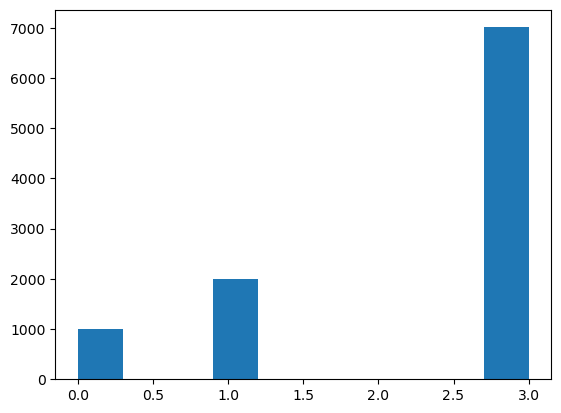

In [4]:
# if requires_grad = True, we need to pass the histrogram function a numpy array instead of a tensor
plt.hist(samples.detach().numpy())

#### Q1.b - Bonus

In [5]:
def vose_alias_tables(dist):
    n = len(dist)
    # tensor for the alias table
    alias = torch.empty(n)
    # for the scaled distributions in the range [0, n-1]
    prob = torch.empty(n)
    small, large = [], []
    scaled_dist = dist * n
    # appending the small list the scaled probabilities that are lower than 1
    small_indices = (scaled_dist < 1)
    # appending the small list the indices of the probabilities that are at most 1/n
    small.extend(list(small_indices.nonzero()))
    # appending the large list the complement of small
    large.extend(list((~small_indices).nonzero()))
    # generating the prob and alias tables using the respective indices in each list
    while small and large:
        l = int(small.pop())
        g = int(large.pop())
        prob[l] = scaled_dist[l]
        alias[l] = g
        # decrementing 1 for more stability (could decrement the average as well)
        scaled_dist[g] += scaled_dist[l] - 1
        if scaled_dist[g] < 1:
            small.append(g)
        else:
            large.append(g)

    while large:
        g = large.pop()
        prob[g] = 1
        
    while small:
        l = small.pop()
        prob[l] = 1

    alias = alias.type(torch.int)
    return alias, prob

In [6]:
def my_sampler_bonus(size, dist, requires_grad=False):
    dist = torch.tensor(dist)
    if torch.sum(dist) != 1.0:
        raise RuntimeError('Sum of probablities is not 1!')
    if torch.any(dist <= 0):
        raise RuntimeError('Probabilities can\'t be non-positive!')
    # creating the tables
    alias, prob = vose_alias_tables(dist)
    # generating the uniform random variate
    x = torch.rand(size, dtype=torch.float)
    n = len(dist)
    # getting a uniformly distributed number on [0, n-1] instead [1, n] because we're working with indices
    i = x * n
    i = i.type(torch.int64) # for using as indices
    # y is in [0, 1)
    y = n * x - i
    # getting all the elements from the respective tensors in the indices we got in the i tensor
    U, K = torch.gather(prob, dim=0, index=i), torch.gather(alias, dim=0, index=i)
    # setting the values accordingly
    output = torch.where(y < U, i, K)
    output = output.type(torch.float)
    output.requires_grad = requires_grad
    return output

In [7]:
samples = my_sampler_bonus(num_samples, dist, True)

(array([ 981.,    0.,    0.,    0.,    0., 2020.,    0.,    0.,    0.,
        6999.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

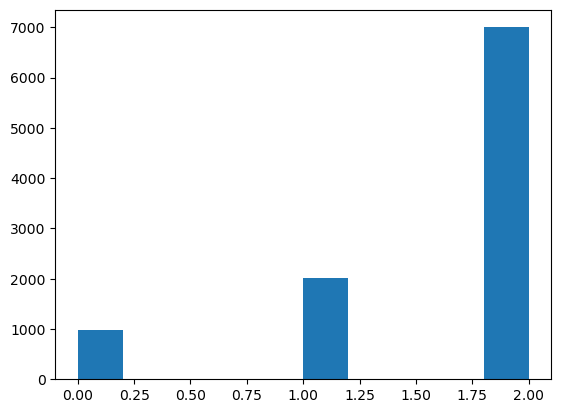

In [8]:
plt.hist(samples.detach().numpy())

### Q2

#### Q2.a

In [9]:
import math

class MyScalar:

    def __init__(self, value, parent=None):
        self.value = value
        self.derivative_value = 1
        self.parent = parent
        self.son = None
        # setting the current object as the son of the parent, if exists
        # will help in implementation of get_gradient
        if parent:
            parent.son = self
            
    # overriding some operators for easier usage
    def __add__(self, n):
        b = MyScalar(self.value, self)
        b.value += n
        # dx/dx = 1
        b.derivative_value = 1
        return b
    
    def __neg__(self):
        self.value = -self.value
        self.derivative_value = -self.derivative_value
        return self
    
    def __mul__(self, n):
        b = MyScalar(self.value, self)
        b.value *= n
        # dnx/dx = n
        b.derivative_value = n
        return b
    
    def __pow__(self, n, modulo=None):
        b = MyScalar(self.value, self)
        b.value = self.value ** n
        # d(x^n)/dx = n * x^(n-1)
        b.derivative_value = n * (self.value ** (n-1))
        return b
    
    def cos(self):
        b = MyScalar(self.value, self)
        b.value = math.cos(self.value)
        # dcosx/dx = -sinx
        b.derivative_value = -math.sin(self.value)
        return b
    
    def sin(self):
        b = MyScalar(self.value, self)
        b.value = math.sin(self.value)
        # dsinx/dx = cosx
        b.derivative_value = math.cos(self.value)
        return b
    
    def ln(self):
        b = MyScalar(self.value, self)
        if self.value <= 0:
            raise RuntimeError('Can\'t apply the logarithm function on non-positive number!')
        b.value = math.log(self.value)
        # dlnx/dx = 1/x
        b.derivative_value = 1/self.value
        return b
    
    def exp(self):
        b = MyScalar(self.value, self)
        b.value = math.exp(self.value)
        # de^x/dx = e^x
        b.derivative_value = math.exp(self.value)
        return b
    
    def calculate_gradients(self, derivatives, grad):
        # reached the first independent object
        if not self.parent:
            derivatives[self] = grad
            return derivatives
        # setting the current object's gradient value to the current calculated gradient value
        derivatives[self] = grad
        # dz/dx = dz/dy * dy/dx
        # applying the chain rule
        grad *= self.derivative_value
        # calculating the next derivative
        self.parent.calculate_gradients(derivatives, grad)
        return derivatives
    
    def get_gradient(self):
        # self's gradient is 1 as dx/dx = 1
        grad = 1
        # wrapping the recursive function with default initial values for simplicity
        return self.calculate_gradients(derivatives={}, grad=grad)


In [10]:
def get_grad(tensor, source_tensor, retain_graph=True):
    # prevent from gradients to be accumulated
    source_tensor.grad = None
    # retaining the hierarchy graph of the tensors' definition
    tensor.backward(retain_graph=retain_graph)
    return tensor.grad

In [11]:
def print_address(scalar_obj, scalar_name, derivatives):
    print(f'{scalar_name}: {derivatives[scalar_obj]}')

#### Q2 - Tests

##### Q2 - Test 1

In [12]:
a = MyScalar(3.0)
b = a.exp()
c = b ** 4
d = c + 3
e = d ** 2
grads = e.get_gradient()

scalars = {
    'a': a,
    'b': b,
    'c': c,
    'd': d,
    'e': e
}

for key, value in scalars.items():
    print_address(value, key, grads)

a_torch = torch.tensor([3.0], requires_grad=True, dtype=torch.float)
b_torch = torch.exp(a_torch)
c_torch = torch.pow(b_torch, 4)
d_torch = c_torch + 3
e_torch = torch.pow(d_torch, 2)

# for getting all gradients
b_torch.retain_grad()
c_torch.retain_grad()
d_torch.retain_grad()
e_torch.retain_grad()

# calculating the gradients
e_torch.backward()

tensors = {
    a: a_torch,
    b: b_torch,
    c: c_torch,
    d: d_torch,
    e: e_torch
}
print('Implementation\t\t\tPyTorch')

for tensor in tensors.keys():
    print(f'{grads[tensor]} --- {tensors[tensor].grad}')

a: 211916883153.74185
b: 10550720349.87998
c: 325515.58283800783
d: 325515.58283800783
e: 1
Implementation			PyTorch
211916883153.74185 --- tensor([2.1192e+11])
10550720349.87998 --- tensor([1.0551e+10])
325515.58283800783 --- tensor([325515.5938])
325515.58283800783 --- tensor([325515.5938])
1 --- tensor([1.])


##### Q2 - Test 2

In [13]:
x = MyScalar(2)
y = x ** 2
z = -y.cos() # setting a minus to avoid runtime error for the log function
w = z.ln()
grads = w.get_gradient()

x_torch = torch.tensor([2], requires_grad=True, dtype=torch.float)
y_torch = x_torch ** 2
z_torch = -torch.cos(y_torch)
w_torch = torch.log(z_torch)

y_torch.retain_grad()
z_torch.retain_grad()
w_torch.retain_grad()

w_torch.backward()

tensors = {
    x: x_torch,
    y: y_torch,
    z: z_torch,
    w: w_torch
}
print('Implementation\t\t\tPyTorch')

for tensor in tensors.keys():
    print(f'{grads[tensor]} --- {tensors[tensor].grad}')

Implementation			PyTorch
-4.63128512939831 --- tensor([-4.6313])
-1.1578212823495775 --- tensor([-1.1578])
1.5298856564663974 --- tensor([1.5299])
1 --- tensor([1.])
